<a href="https://colab.research.google.com/github/ghubnerr/machine-learning/blob/main/jax/flax_cnns_rnns_lstms.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Building Basic Neural Networks with Jax

`credit to Gabriel Lucchesi & David Ulloa <3`

In [ ]:
import os

import jax
from jax import grad
from jax import random
import flax
from flax import linen as nn
import jax.numpy as jnp
import numpy as np
from flax.training import train_state
import optax
import matplotlib.pyplot as plt
from tqdm.autonotebook import trange, tqdm
import orbax.checkpoint as orbax
import flax.serialization

# How we set a seed in jax
key = jax.random.PRNGKey(42)

<ipython-input-1-bbe62fbba0e0>:13: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import trange, tqdm


## Basics

To not belabor what we've already done in the ["Intro to Gradient Descent"](https://gist.github.com/DavidUlloa6310/b8e93cb20e60f2a9d626a9bfe0a8b0bf) notebook, let's quickly explore doing our basic linear regreesion model in Jax instead of by hand.

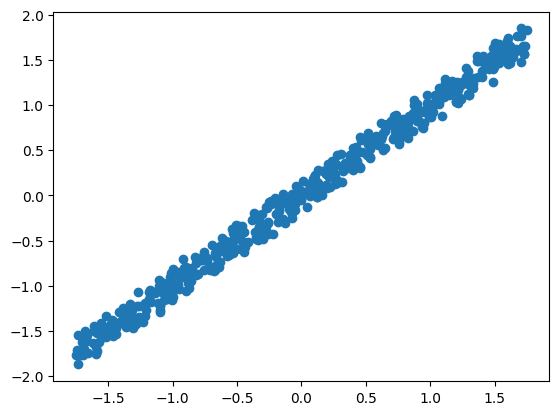

In [ ]:
# Prepare dataset
SAMPLES = 500
x = np.arange(1, SAMPLES)
np.random.shuffle(x)

y = 0.3 * x + 5
x += np.random.randint(0, 15, size=len(x))
y += np.random.randint(0, 15, size=len(y))

x = (x - x.mean()) / x.std()
y = (y - y.mean()) / y.std()

split = int(SAMPLES * 0.8)
x_train, y_train = x[:split], y[:split]
x_test,  y_test  = x[split:], y[split:]

plt.scatter(x, y)

In [ ]:
def predict(params, x):
    w, b = params
    return w * x + b

def mse_loss(params, x, y):
    preds = predict(params, x)
    return jnp.mean((preds - y) ** 2)

w = jnp.array(np.random.rand(1, 1))
b = jnp.array(np.random.rand(1, 1))
params = (w, b)

EPOCHS = 2500
LEARNING_RATE = 0.001

loss_grad = grad(mse_loss, argnums=0)
for epoch in range(EPOCHS):
    dw, db = loss_grad(params, x_train, y_train)

    loss = mse_loss(params, x, y)

    dw, db = loss_grad(params, x, y)

    w -= LEARNING_RATE * dw
    b -= LEARNING_RATE * db
    params = (w, b)

    if epoch % 500 == 0:
        print(f"Epoch {epoch}: Loss = {loss:.4f}, w = {w[0][0]:.4f}, b = {b[0][0]:.4f}")

print(f"\nFinal model: y = {w[0][0]:.4f} * x + {b[0][0]:.4f}")

Epoch 0: Loss = 1.6948, w = 0.0052, b = 0.8357
Epoch 500: Loss = 0.2376, w = 0.6312, b = 0.3071
Epoch 1000: Loss = 0.0408, w = 0.8613, b = 0.1129
Epoch 1500: Loss = 0.0142, w = 0.9458, b = 0.0415
Epoch 2000: Loss = 0.0106, w = 0.9769, b = 0.0152

Final model: y = 0.9883 * x + 0.0056


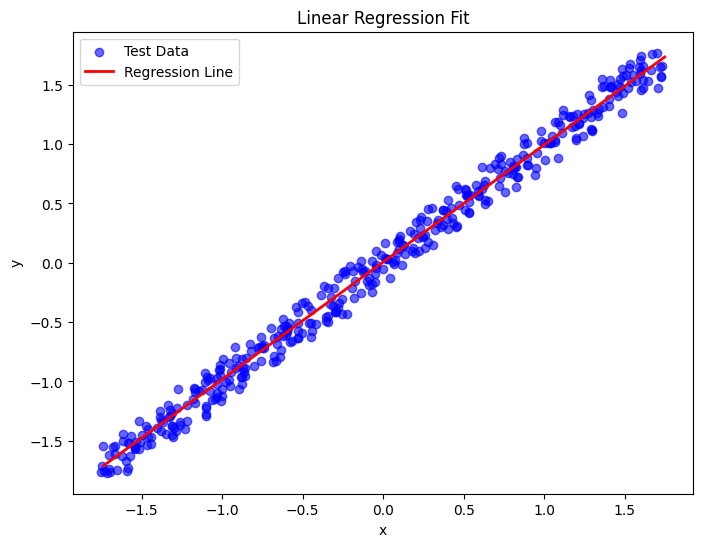

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import jax.numpy as jnp

# Generate a range of x values for plotting the regression line
x_range = np.linspace(x_test.min(), x_test.max(), 100).reshape(-1, 1)

# Compute predictions over the range
y_pred = predict(params, jnp.array(x_range))

# Plot the training data and the regression line
plt.figure(figsize=(8, 6))
plt.scatter(x_train, y_train, label='Test Data', color='blue', alpha=0.6)
plt.plot(x_range, np.array(y_pred), label='Regression Line', color='red', linewidth=2)
plt.xlabel('x')
plt.ylabel('y')
plt.title('Linear Regression Fit')
plt.legend()
plt.show()

You might notice that our "forward" pass (or inference on the model) isn't shown as directly in the code as before. Instead, we're calling the `grad` function on our `MSE` function and from there updating the weights accordingly.

Isn't that interesting? Jax is able to calculate the gradients with respect to each variable as a function - not like PyTorch which collects the gradients through your forward pass.

## A Multi-Layer Perceptron (MLP)

A multi-layer perception is as it sounds, a neural network with a series of usually dense layers. Using the Jax code we've already seen, we can make one pretty simply.


In [ ]:
import tensorflow_datasets as tfds

ds_builder = tfds.builder('mnist')
ds_builder.download_and_prepare()

ds_train = tfds.as_numpy(ds_builder.as_dataset(split='train', batch_size=-1))
ds_test  = tfds.as_numpy(ds_builder.as_dataset(split='test',  batch_size=-1))

train_images, train_labels = ds_train['image'], ds_train['label']
test_images, test_labels = ds_test['image'], ds_test['label']

# Preprocess the images:
# 1. Convert to float32 and normalize to [0, 1]
# 2. Reshape images from 28x28 (or 28x28x1) to a flat vector of 784 features
train_images = jnp.reshape(jnp.array(train_images, dtype=jnp.float32) / 255.0, (-1, 28 * 28))
test_images = jnp.reshape(jnp.array(test_images, dtype=jnp.float32) / 255.0, (-1, 28 * 28))
train_labels = jnp.array(train_labels, dtype=jnp.int32)
test_labels = jnp.array(test_labels, dtype=jnp.int32)

print("Train images shape:", train_images.shape)
print("Test images shape:", test_images.shape)

Train images shape: (60000, 784)
Test images shape: (10000, 784)


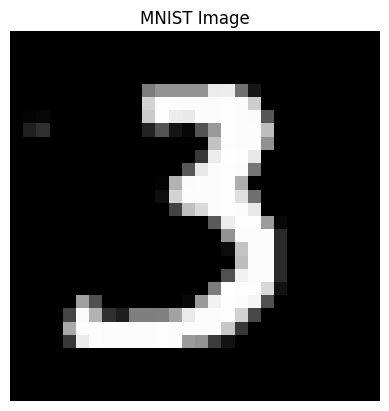

In [ ]:
image = np.array(random.choice(key, train_images)).reshape(28, 28)

plt.imshow(image, cmap='gray')
plt.title("MNIST Image")
plt.axis('off')
plt.show()

One thing you might see that's interesting below is something called "Xavier Initialization". There is a science behind "randomly" selecting the right values to initialize our network, but for now you can read up more [here](https://arc.net/l/quote/jaffrwiz).

In [ ]:
layer_sizes = [784, 128, 64, 10]

# Defininig Our Model
class MLP(nn.Module):
    hidden_sizes: list[int]
    output_size: int

    @nn.compact
    def __call__(self, x):
        for size in self.hidden_sizes:
            x = nn.relu(nn.Dense(size, kernel_init=nn.initializers.xavier_uniform())(x))
        x = nn.Dense(self.output_size, kernel_init=nn.initializers.xavier_uniform())(x)
        return x

    # TrainState helps organize our parameters and update them
    def create_train_state(self, rng, learning_rate):
        params = self.init(rng, jnp.ones([1, 784]))['params']
        tx = optax.adam(learning_rate)
        return train_state.TrainState.create(
            apply_fn=self.apply,
            params=params,
            tx=tx
        )

In the multi-category classification task, we'll be using a loss function called cross-entropy loss

$$
L = -\sum_{c=1}^{C} y_c \log(p_c)
$$

which penalizes based on our predicted probability for each label. $y_c$ in this case is 1 when that's the class we're trying to predict or 0 otherwise. If we're predicting which digit is in an image our true probabilities look like this:

$$
Y = [0, 0, 0, 1, 0, 0, 0, 0, 0, 0]
$$

while our probabilities look like:

$$
P = [0.1, 0.1, 0.1, 0.4, 0.05, 0.05, 0.1, 0.0025, 0.05, 0.0025]
$$

meaning our model predicts the digit "3" is most likely, which is correct looking at $Y$. We want to optimize our model by making the loss as small as possible, so the larger the probability for the digit "3" is, the smaller our loss is.

Our activation will be the softmax function, which normalizes the output of our neural network into a probability distribution (something like $P$ in the previous example, which sums to 1).

$$
p_c = \frac{e^{z_c}}{\sum_{j=1}^{C} e^{z_j}}
$$

By default at the end of our model, our network outputs a vector of size 10, but it could look like anything (as shown below). We need to could just take the largest number to find the accurate response, but we want optimize our model and normalizing the responses between [0, 1] helps us do that.

$$
Logits = [0.42, 1.4, 0.22, 6.32, 0.80, 0.80, ...]
$$


In [ ]:
def loss_fn(params, state, x, y):
    logits = state.apply_fn({'params': params}, x)
    loss = optax.softmax_cross_entropy_with_integer_labels(logits=logits, labels=y)
    return jnp.mean(loss)

def compute_accuracy(state, params, x, y):
    logits = state.apply_fn({'params': params}, x)
    predictions = jnp.argmax(logits, axis=1)
    return jnp.mean(predictions.astype(jnp.int32) == y)

# @jax.jit breaks down our function and optimizes - unique to Jax
# Other libraries would need to write custom "kernals" for operations to make them efficient
@jax.jit
def train_step(state, batch):
    x_batch, y_batch = batch
    grad_fn = jax.grad(loss_fn)
    grads = grad_fn(state.params, state, x_batch, y_batch)
    return state.apply_gradients(grads=grads)

In [ ]:
model = MLP(layer_sizes[:-1], layer_sizes[-1])
state = model.create_train_state(key, learning_rate=0.001)

# Epoch - how many times will our model go over the entire dataset
EPOCHS = 10
# Batch Size - how many times will our model collect the "gradients" before updating the weights
# https://arxiv.org/pdf/1502.03167
BATCH_SIZE = 32

# Training Loop
for epoch in trange(EPOCHS):
    perm = jax.random.permutation(key, len(train_images))
    train_images_shuffled = train_images[perm]
    train_labels_shuffled = train_labels[perm]

    for i in trange(0, len(train_images), BATCH_SIZE):
        batch = (
            train_images_shuffled[i:i+BATCH_SIZE],
            train_labels_shuffled[i:i+BATCH_SIZE]
        )
        state = train_step(state, batch)

    train_acc = compute_accuracy(state, state.params, train_images, train_labels)
    test_acc = compute_accuracy(state, state.params, test_images, test_labels)
    current_loss = loss_fn(state.params, state, train_images, train_labels)

    print(f"Epoch {epoch+1}: Loss: {current_loss:.4f}, "
          f"Train Accuracy: {train_acc:.4f}, Test Accuracy: {test_acc:.4f}")

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1875 [00:00<?, ?it/s]

Epoch 1: Loss: 0.0961, Train Accuracy: 0.9715, Test Accuracy: 0.9681


  0%|          | 0/1875 [00:00<?, ?it/s]

Epoch 2: Loss: 0.0603, Train Accuracy: 0.9807, Test Accuracy: 0.9744


  0%|          | 0/1875 [00:00<?, ?it/s]

Epoch 3: Loss: 0.0545, Train Accuracy: 0.9835, Test Accuracy: 0.9728


  0%|          | 0/1875 [00:00<?, ?it/s]

Epoch 4: Loss: 0.0334, Train Accuracy: 0.9889, Test Accuracy: 0.9773


  0%|          | 0/1875 [00:00<?, ?it/s]

Epoch 5: Loss: 0.0340, Train Accuracy: 0.9895, Test Accuracy: 0.9775


  0%|          | 0/1875 [00:00<?, ?it/s]

Epoch 6: Loss: 0.0251, Train Accuracy: 0.9920, Test Accuracy: 0.9773


  0%|          | 0/1875 [00:00<?, ?it/s]

Epoch 7: Loss: 0.0255, Train Accuracy: 0.9920, Test Accuracy: 0.9801


  0%|          | 0/1875 [00:00<?, ?it/s]

Epoch 8: Loss: 0.0175, Train Accuracy: 0.9947, Test Accuracy: 0.9808


  0%|          | 0/1875 [00:00<?, ?it/s]

Epoch 9: Loss: 0.0264, Train Accuracy: 0.9920, Test Accuracy: 0.9788


  0%|          | 0/1875 [00:00<?, ?it/s]

Epoch 10: Loss: 0.0161, Train Accuracy: 0.9949, Test Accuracy: 0.9807


In [ ]:
from flax.training import checkpoints

# An easy way to save checkpoints in Jax
ckpt_dir = "/content/mnist_checkpoint"
os.makedirs(ckpt_dir, exist_ok=True)
checkpoints.save_checkpoint(ckpt_dir, state, step=EPOCHS)

## A Convolutional Neural Network (CNN)

A CNN, as explained in the slides, involves a "kernel" which is a small matrix which slides over the image, learning different patterns. The CNNs we know now (meaning trained through gradient descent) was invented by 1989 by Yann LeCun, who you might know as the Chief AI Scientist at Meta.

![](https://cdn.analyticsvidhya.com/wp-content/uploads/2020/10/90650dnn2.webp)

This architecture can be seen as an "inductive bias" which means we build our neural network in a pattern which biases the model to learn a way *we believe* works. A great video on this is 3blue1brown's ["But what is a convolution?"](https://www.youtube.com/watch?v=KuXjwB4LzSA&t=1221s)

In [ ]:
xavier = nn.initializers.xavier_uniform

In [ ]:
class CNN(nn.Module):
    @nn.compact
    def __call__(self, x):
        x = nn.Conv(features=32, kernel_size=(5,5), kernel_init=xavier())(x)
        x = nn.relu(x)
        x = nn.max_pool(x, window_shape=(2,2), strides=(2,2))
        x = nn.Conv(features=64, kernel_size=(5,5), kernel_init=xavier())(x)
        x = nn.relu(x)
        x = nn.max_pool(x, window_shape=(2,2), strides=(2,2))
        x = x.reshape((x.shape[0], -1)) # flatten
        x = nn.Dense(features=256, kernel_init=xavier())(x)
        x = nn.relu(x)
        x = nn.Dense(features=10, kernel_init=xavier())(x)
        x = nn.log_softmax(x)
        return x

    def create_train_state(self, rng, learning_rate):
        params = self.init(rng, jnp.ones([1, 28, 28, 1]))['params']
        tx = optax.adam(learning_rate)
        return train_state.TrainState.create(
            apply_fn=self.apply,
            params=params,
            tx=tx
        )

In [ ]:
@jax.jit
def train_step(state, batch):
    x_batch, y_batch = batch
    grad_fn = jax.grad(loss_fn)
    grads = grad_fn(state.params, state, x_batch, y_batch)
    return state.apply_gradients(grads=grads)

# We grouped the "compute_accuracy" and "loss_fn" so we only have to go through the dataset once
# As you'll see, this model is a lot slower, so these tiny changes speed up the process
def compute_metrics(state, params, images, labels, batch_size=8):
    total_loss = 0.0
    total_correct = 0
    total_examples = 0
    for i in range(0, len(images), batch_size):
        batch_x = images[i:i+batch_size]
        batch_y = labels[i:i+batch_size]
        logits = state.apply_fn({'params': params}, batch_x)

        # Compute loss for this batch
        loss = optax.softmax_cross_entropy_with_integer_labels(logits=logits, labels=batch_y)
        total_loss += jnp.sum(loss)

        # Compute accuracy for this batch
        predictions = jnp.argmax(logits, axis=-1)
        total_correct += jnp.sum(predictions == batch_y)
        total_examples += len(batch_x)

    avg_loss = total_loss / total_examples
    accuracy = total_correct / total_examples
    return avg_loss.item(), accuracy.item()

In [ ]:
model = CNN()
state = model.create_train_state(key, learning_rate=0.001)

EPOCHS = 3
BATCH_SIZE = 4

# Unlike our MLP, our CNN expects (28, 28, 1)
train_images = train_images.reshape(-1, 28, 28, 1)
test_images = test_images.reshape(-1, 28, 28, 1)

print("Train images shape:", train_images.shape)
print("Test images shape:", test_images.shape)

for epoch in trange(EPOCHS):
    perm = jax.random.permutation(key, len(train_images))
    train_images_shuffled = train_images[perm]
    train_labels_shuffled = train_labels[perm]

    for i in trange(0, len(train_images), BATCH_SIZE):
        batch = (
            train_images_shuffled[i:i+BATCH_SIZE],
            train_labels_shuffled[i:i+BATCH_SIZE]
        )
        state = train_step(state, batch)

    train_loss, train_acc = compute_metrics(state, state.params, train_images, train_labels, batch_size=128)
    test_loss, test_acc = compute_metrics(state, state.params, test_images, test_labels, batch_size=128)
    print(f"Epoch {epoch+1}: Loss: {train_loss:.4f}, "
      f"Train Accuracy: {train_acc:.4f}, Test Accuracy: {test_acc:.4f}")

Train images shape: (60000, 28, 28, 1)
Test images shape: (10000, 28, 28, 1)


  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/15000 [00:00<?, ?it/s]

Epoch 1: Loss: 0.0420, Train Accuracy: 0.9870, Test Accuracy: 0.9861


  0%|          | 0/15000 [00:00<?, ?it/s]

Epoch 2: Loss: 0.0262, Train Accuracy: 0.9919, Test Accuracy: 0.9874


  0%|          | 0/15000 [00:00<?, ?it/s]

Epoch 3: Loss: 0.0415, Train Accuracy: 0.9896, Test Accuracy: 0.9866


## Testing Our Model

In [ ]:
def predict_digit(state, img):
    if len(img.shape) == 3:
        img = img[np.newaxis, ...]
    logits = state.apply_fn({'params': state.params}, img)
    return jnp.argmax(logits, axis=-1)[0].item()

##### Helper Methods

In [ ]:
!pip install ipycanvas ipywidgets ipympl

In [ ]:
import ipycanvas
import ipywidgets as widgets
from ipycanvas import Canvas
import numpy as np
from IPython.display import display
from google.colab import output
output.enable_custom_widget_manager()

%matplotlib inline

In [ ]:
drawing = False
points = []

def start_drawing(x, y):
    global drawing
    drawing = True
    canvas.begin_path()
    canvas.move_to(x, y)
    points.append((x, y))

def draw(x, y):
    global drawing
    if drawing:
        canvas.line_to(x, y)
        canvas.stroke()
        points.append((x, y))

def stop_drawing(x, y):
    global drawing
    drawing = False
    img = points_to_array()
    prediction = predict_digit(state, img)
    prediction_label.value = f'Predicted Digit: {prediction}'

def clear_canvas(b):
    canvas.clear()
    canvas.fill_style = 'black'
    canvas.fill_rect(0, 0, 140, 140)
    points.clear()
    prediction_label.value = 'Draw a digit...'

def exit_app(b):
    canvas.close()
    clear_btn.close()
    exit_btn.close()
    prediction_label.close()

def points_to_array():
    img = np.zeros((28, 28, 1), dtype=np.float32)
    for x, y in points:
        ix = int(x * 28 / 140)
        iy = int(y * 28 / 140)
        if 0 <= ix < 28 and 0 <= iy < 28:
            img[iy, ix] = 1.0
    img = img[np.newaxis, ...]
    return img

### Draw a digit below

In [ ]:
canvas = Canvas(width=140, height=140)
canvas.line_width = 20
canvas.stroke_style = 'white'
canvas.stroke_circle(10, 10, 10)

clear_btn = widgets.Button(description='Clear')
exit_btn = widgets.Button(description='Exit')
prediction_label = widgets.Label(value='Draw a digit...')

button_box = widgets.HBox([clear_btn, exit_btn])
display(widgets.VBox([canvas, button_box, prediction_label]))

canvas.on_mouse_down(start_drawing)
canvas.on_mouse_move(draw)
canvas.on_mouse_up(stop_drawing)
clear_btn.on_click(clear_canvas)
exit_btn.on_click(exit_app)

clear_canvas(None)

## Recurrent Neural Networks (RNNs)

RNNs work on the basic idea of having a series of networks which work on the input and considering the previous transformations on the input along with the current node's transformation. As an equation, you can think of it like this:

$$
Carry_{new} = Activation(W_xx + W_hCarry_{old}+ b)
$$

In this equation, we have a carry and we're multiplying it by the previous network, while at the same time passing the input to the current network, summing those results. The output from this whole operation is now the carry for the next node in the RNN, which will also receive the input once again. As the name implies, an RNN works on recurrent connections.

In [ ]:
!pip install datasets -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 484.9/484.9 kB 11.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 9.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 9.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 9.9 MB/s eta 0:00:00


In [ ]:
from typing import Optional
import orbax.checkpoint as orbax
import random
from datasets import load_dataset
import re
from collections import defaultdict

#### What are RNNs useful for?

Because of their nature of remembering previous states and learning when to attribute importance to its internal memory, RNNs are very good at sequential classification tasks! What's a good example of sequential classification task, you may ask? *Language!*

If we frame our sequential classification problem as classifying between certain unique words based on our previous words, we'll get something very close to how us humans formulate and learn to  choose our next words. For that reason, the next few steps will be about **framing our language problem as a series of classification tasks**. The first step? **The classes**.

In language modeling, our classes are known as tokens, and we'll always (or very much often) like to get the next best word to formulate our sentence. For that, there's different techniques we can use to make up our **vocabulary**.

Here, we'll do something called **byte-pair encoding**, where we'll read over our entire **corpus** and figure out which characters come close to which the most often, and group that as an extra character in our vocabulary!

> i.e:     `aaabdaaabac`
>    => `ZabdZabac`; `(Z=aa)`=> `ZYdZYac`; `(Y=ab)`; =>`XdXac`;`(X=ZY)`
>  

In [ ]:
dataset = load_dataset('wikitext', 'wikitext-103-raw-v1', split='train')

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/10.5k [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/733k [00:00<?, ?B/s]

train-00000-of-00002.parquet:   0%|          | 0.00/157M [00:00<?, ?B/s]

train-00001-of-00002.parquet:   0%|          | 0.00/157M [00:00<?, ?B/s]

validation-00000-of-00001.parquet:   0%|          | 0.00/657k [00:00<?, ?B/s]

Generating test split:   0%|          | 0/4358 [00:00<?, ? examples/s]

Generating train split:   0%|          | 0/1801350 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/3760 [00:00<?, ? examples/s]

In [ ]:
print(dataset)

Dataset({
    features: ['text'],
    num_rows: 1801350
})


We have **millions** of rows of **plain text** in our corpus. That's a mouthful of labels to train our model!

In [ ]:
import random
for row in random.sample(dataset['text'], 2):
    prev = []
    for i, word in enumerate(row.strip().split(" ")[:-1]):
        prev.append(word)
        print("Input:", " ".join(prev), '____', f'Label: {row.strip().split(" ")[i+1]}')

Input: While ____ Label: organizing
Input: While organizing ____ Label: his
Input: While organizing his ____ Label: room
Input: While organizing his room ____ Label: ,
Input: While organizing his room , ____ Label: Double
Input: While organizing his room , Double ____ Label: Dee
Input: While organizing his room , Double Dee ____ Label: (
Input: While organizing his room , Double Dee ( ____ Label: Samuel
Input: While organizing his room , Double Dee ( Samuel ____ Label: Vincent
Input: While organizing his room , Double Dee ( Samuel Vincent ____ Label: )
Input: While organizing his room , Double Dee ( Samuel Vincent ) ____ Label: notices
Input: While organizing his room , Double Dee ( Samuel Vincent ) notices ____ Label: that
Input: While organizing his room , Double Dee ( Samuel Vincent ) notices that ____ Label: his
Input: While organizing his room , Double Dee ( Samuel Vincent ) notices that his ____ Label: magnifying
Input: While organizing his room , Double Dee ( Samuel Vincent ) no

The difference here is that I've treated every word as a token, which becomes a problem because the vocabulary size will grow without bounds since any string can be made up of any characters, and of any length. That's why we need this **finite set of tokens** we call the **vocabulary**, so that it's big enough to be able to **build the words themselves**.

There are already pre-made tokenizers that we can leveraged. They have already scanned the entire internet for tokens! We're assuming the internet and this dataset follow the same distribution, which is a fair claim.

In [ ]:
!pip install tiktoken -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 11.6 MB/s eta 0:00:00


In [ ]:
import tiktoken
enc = tiktoken.get_encoding("gpt2")

In [ ]:
text_input = "Hello, how are you today? Did you know Gabe is taller than David?"

token_ids = enc.encode(text_input)
print("Token IDs:", token_ids)

x = jnp.array(token_ids)[None, :]

Token IDs: [15496, 11, 703, 389, 345, 1909, 30, 7731, 345, 760, 45513, 318, 25242, 621, 3271, 30]


In [ ]:
print(enc.n_vocab)

50257


In [ ]:
print(enc.special_tokens_set)

{'<|endoftext|>'}


So now we have a way of uniquely identifying which tokens correspond to what labels in a classification problem. Our MLP at the end would look like this. Which is the distribution of odds that the RNN would pick these tokens as the next word.

```
logits = nn.Dense(featues=50257, kernel_init=xavier())(x)
```

### Training an sequence modeling problem given a set of sequences

The token IDs are concatenated and reshaped into batches, where each batch contains an input sequence (`x`) and its corresponding target sequence (y), which is shifted by one token like the example above.

In [ ]:
def tokenize_and_batch(dataset, batch_size, seq_length, enc):
    tokenized = []
    for line in dataset['text']:
        line = line.strip()
        if line:  # Skip empty lines.
            token_ids = enc.encode(line)
            tokenized.extend(token_ids)

    # Ensure we only use complete batches.
    num_batches = len(tokenized) // (batch_size * (seq_length + 1))
    tokenized = tokenized[: num_batches * batch_size * (seq_length + 1)]
    token_array = np.array(tokenized).reshape((batch_size, -1))

    batches = []
    for i in range(0, token_array.shape[1] - seq_length, seq_length):
        x = token_array[:, i : i + seq_length]
        y = token_array[:, i + 1 : i + seq_length + 1]
        batches.append((x, y))
    return batches

For simplicity, we'll be calling the $Carry_i$ state $h_i$, as in "hidden"

In [ ]:
class RNN(nn.Module):
    vocab_size: int
    embed_dim: int
    hidden_size: int

    def setup(self):
        self.embed = nn.Embed(num_embeddings=self.vocab_size, features=self.embed_dim)
        self.dense_x = nn.Dense(self.hidden_size, kernel_init=xavier())
        self.dense_h = nn.Dense(self.hidden_size, kernel_init=xavier())
        self.dense_out = nn.Dense(self.vocab_size)

    def __call__(self, x, h: Optional[jnp.ndarray] = None):
        # x: (batch_size, sequence_length)
        # h: Optional(batch_size, hidden_size)
        batch_size, sequence_length = x.shape

        # There is no previous carry state in the first word
        if h is None:
            h = jnp.zeros((batch_size, self.hidden_size))

        x = self.embed(x)

        outputs = []
        for token in range(sequence_length):
            # Get the current timestep's embeddings
            x_t = x[:, token, :] # (batch_size, embed_dim)

            # W_x * x_t + b_x + W_h * h_old + b_h (equation above)
            h_new = jnp.tanh(
                self.dense_x(x_t) +
                self.dense_h(h)
            )

            outputs.append(h_new)
            h = h_new

        # Stacking along the time dimension the (sequence)
        outputs = jnp.stack(outputs, axis=1)

        # Get logits back (values for every word in our vocabulary)
        logits = self.dense_out(outputs)
        return logits, h

In [ ]:
def create_train_state(rng, model, learning_rate, batch_size, hidden_size):
    dummy_x = jnp.ones((batch_size, 10), dtype=jnp.int32)
    dummy_h = jnp.zeros((batch_size, hidden_size))
    params = model.init(rng, dummy_x, dummy_h)['params']
    tx = optax.adam(learning_rate)
    return train_state.TrainState.create(apply_fn=model.apply, params=params, tx=tx)

In [ ]:
def compute_loss(params, apply_fn, batch, h, rng):
    x, y = batch
    logits, new_h = apply_fn({'params': params}, x, h)
    loss = optax.softmax_cross_entropy_with_integer_labels(logits, y).mean()
    return loss, new_h

In [ ]:
@jax.jit
def train_step(state, batch, h, rng):
    grad_fn = jax.value_and_grad(compute_loss, has_aux=True)
    (loss, new_h), grads = grad_fn(state.params, state.apply_fn, batch, h, rng)
    state = state.apply_gradients(grads=grads)
    return state, loss, new_h

In [ ]:
embed_dim = 128
hidden_size = 256
batch_size = 32
seq_length = 35
learning_rate = 1e-3
num_epochs = 1

In [ ]:
batches = tokenize_and_batch(dataset, batch_size, seq_length, enc)

In [ ]:
from flax.training import orbax_utils

ckpt_dir = "/checkpoints/rnn-checkpoints"


options = orbax.CheckpointManagerOptions(max_to_keep=3, create=True)
checkpoint_manager = orbax.CheckpointManager(
    ckpt_dir,
    orbax.PyTreeCheckpointer(),
    options=options
)

In [ ]:
vocab_size = enc.n_vocab

rng = jax.random.PRNGKey(0)
model = RNN(vocab_size=vocab_size, embed_dim=embed_dim, hidden_size=hidden_size)
state = create_train_state(rng, model, learning_rate, batch_size, hidden_size)
h = jnp.zeros((batch_size, hidden_size))

# Training loop.
for epoch in trange(num_epochs):
    # Optionally, reset the hidden state at the start of each epoch (For vanishing gradient avoiding)
    h = jnp.zeros((batch_size, hidden_size))
    for batch in tqdm(batches):
        rng, step_rng = jax.random.split(rng)
        state, loss, h = train_step(state, batch, h, step_rng)
    print(f"Epoch {epoch+1}, Loss: {loss:.4f}")


In [ ]:
save_args = orbax_utils.save_args_from_target(state)

In [ ]:
checkpoints.save_checkpoint(ckpt_dir, state, step=epoch, overwrite=True)

'/checkpoints/rnn-checkpoints/checkpoint_0'

In [ ]:
seed_text = "Once upon a time, "

In [ ]:
h = jnp.zeros((1, hidden_size))

seed_tokens = enc.encode(seed_text)
print("Seed tokens:", seed_tokens)

# We need to pass the entire seed sequence to update h.
x_seed = jnp.array(seed_tokens)[None, :]  # Shape: (1, seed_length)
_, h = model.apply({'params': state.params}, x_seed, h)

current_token = seed_tokens[-1]
generated_tokens = seed_tokens.copy()

temperature = 1.0

for _ in range(5000):
    x = jnp.array([[current_token]])

    logits, h = model.apply({'params': state.params}, x, h)
    next_logits = logits[0, -1]

    adjusted_logits = next_logits / temperature

    rng, subkey = jax.random.split(rng)
    current_token = int(jax.random.categorical(subkey, adjusted_logits))
    generated_tokens.append(current_token)

generated_text = enc.decode(generated_tokens)


In [ ]:
generated_text

'Once upon a time, urne , a father who can also discuss the EPA \'s administration in opposition from the revolt . Before levelling when the wealthiest senior year .The British withdrawal of the SSI sponsors division owned had gone , the first years after her decision went to a whole . In a convincing from that the Bew \' home book in a newspaper article , The meetings of news set , Mosia were chosen to represent the urban orchestra .With positions . Through the same era , such as antagonists interviews , , including George to pick up and roll . The plan to his starting remarks towards one attachment ; he was named Szoode Scheer , on the body and defeated the Baptist League Premier League Baseball history . Persistent with Revolutionary War Secretary by Culture , past I reported that Lincoln was taken by the influence of Rosalants Privinguinus . Qigon[ Maced to the most valuable stallions of the Old shirt mulled segments were made in purpose of the fortil on 25 August , but he quickly 

### But-- what happened?

Sure, I'm reading English, but there doesn't seem to be much sense to what the model is doing. That's because backpropagation works **terribly** through time. We call that the **vanishing gradient problem**

![image](https://miro.medium.com/v2/resize:fit:1400/1*rPafmg_KaY4PzPiufg-qnw.png)

When you backpropagate through many time steps, the gradients – essentially the signals that tell the network how to update its weights – can become extremely small. In mathematical terms, you're multiplying many small numbers together (each derivative from a time step), and this product tends to shrink exponentially. As a result, the network struggles to learn dependencies from earlier time steps because the updates become negligible. This is why your model might capture short-term patterns, but lose the context needed for coherent long-term sequences.

To fix this, we'll have to introduce a new type of gating mechanisms that control the flow of information, allowing them to retain important signals over longer periods. We call those **LSTMs cells** (long short-term memory cells). Instead of doing this directly: $\text{Carry}_{\text{new}} = \text{Activation}(W_x x + W_h\, \text{Carry}_{\text{old}} + b)$

![image](https://www.researchgate.net/publication/351291905/figure/fig2/AS:1019551378579458@1620091399867/Complete-LSTM-architecture-with-equations-showing-how-information-moves-through-the-cell.ppm)

$$
\begin{aligned}
f_t &= \sigma(W_f \cdot [h_{t-1}, x_t] + b_f) \quad &\text{(forget gate)}\\
i_t &= \sigma(W_i \cdot [h_{t-1}, x_t] + b_i) \quad &\text{(input gate)}\\
o_t &= \sigma(W_o \cdot [h_{t-1}, x_t] + b_o) \quad &\text{(output gate)}\\
\tilde{c}_t &= \tanh(W_c \cdot [h_{t-1}, x_t] + b_c) \quad &\text{(cell candidate)}\\
c_t &= f_t \odot c_{t-1} + i_t \odot \tilde{c}_t \quad &\text{(cell state update)}\\
h_t &= o_t \odot \tanh(c_t) \quad &\text{(hidden state update)}
\end{aligned}
$$

Obviously, there's a simple thingy you import for that. You can read more on this [here]([https://arc.net/l/quote/cfsmjsmj).

The `nn.remat` call saves memory when using LSTMs to compute long sequences.

In [ ]:
def create_initial_carry(batch_size, hidden_size):
    return (jnp.zeros((batch_size, hidden_size)),
            jnp.zeros((batch_size, hidden_size)))

In [ ]:
class LSTMModel(nn.Module):
    vocab_size: int
    embed_dim: int
    hidden_size: int
    num_layers: int = 3

    def setup(self):
        # Embedding layer: converts token IDs to embeddings.
        self.embedding = nn.Embed(
            num_embeddings=self.vocab_size,
            features=self.embed_dim
        )

        # Create multiple scanned LSTM layers using a list comprehension.
        self.lstm_layers = [
            nn.scan(
                nn.OptimizedLSTMCell,
                variable_broadcast="params",
                split_rngs={"params": False},
                in_axes=1,    # Scan over the time dimension
                out_axes=1,   # Collect outputs over time dimension
                length=None,  # Dynamically infer length
                reverse=False
            )(features=self.hidden_size)
            for _ in range(self.num_layers)
        ]

        # Project each timestep's hidden state to vocabulary logits.
        self.output_proj = nn.Dense(self.vocab_size)

    @nn.remat
    def __call__(self, x: jnp.ndarray) -> jnp.ndarray:
        batch_size, seq_len = x.shape

        # Embed the token IDs.
        x = self.embedding(x)  # batch_size, seq_len, embed_dim

        for idx, lstm_layer in enumerate(self.lstm_layers):
            carry = create_initial_carry(batch_size, self.hidden_size)
            carry, x = lstm_layer(carry, x)

        logits = self.output_proj(x)  # batch_size, seq_len, vocab_size
        return logits

In [ ]:
def create_train_state(rng, model, learning_rate, batch_size, seq_length):
    dummy_x = jnp.ones((batch_size, seq_length), dtype=jnp.int32)

    params = model.init(rng, dummy_x)['params']

    tx = optax.adam(learning_rate)
    return train_state.TrainState.create(
        apply_fn=model.apply,
        params=params,
        tx=tx
    )

In [ ]:
@jax.jit
def update_fn(state, batch):
    def loss_fn(params):
        # x: (batch_size, seq_length), y: (batch_size, seq_length)
        x, y = batch

        # logits: (batch_size, seq_length, vocab_size)
        logits = state.apply_fn({'params': params}, x)
        loss = optax.softmax_cross_entropy_with_integer_labels(logits, y).mean()
        return loss

    loss, grads = jax.value_and_grad(loss_fn)(state.params)
    new_state = state.apply_gradients(grads=grads)
    return new_state, loss

In [ ]:
embed_dim = 128
hidden_size = 256
batch_size = 32
seq_length = 35
learning_rate = 1e-3
num_epochs = 1

In [ ]:
vocab_size = enc.n_vocab

model = LSTMModel(
    vocab_size=vocab_size,
    embed_dim=embed_dim,
    hidden_size=hidden_size,
    num_layers=3
)

rng = jax.random.PRNGKey(0)

state = create_train_state(rng, model, learning_rate, batch_size, seq_length)

In [ ]:
for epoch in trange(num_epochs):
    for batch in tqdm(batches):
        rng, step_rng = jax.random.split(rng)
        state, loss = update_fn(state, batch)
    print(f"Epoch {epoch+1}, Loss: {loss:.4f}")

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/103316 [00:00<?, ?it/s]

Epoch 1, Loss: 4.8116


In [ ]:
ckpt_dir = "/checkpoints/optimized-lstm-checkpoints"

options = orbax.CheckpointManagerOptions(max_to_keep=3, create=True)
checkpoint_manager = orbax.CheckpointManager(
    ckpt_dir,
    orbax.PyTreeCheckpointer(),
    options=options
)

In [ ]:
from flax.training import orbax_utils, checkpoints


save_args = orbax_utils.save_args_from_target(state)

In [ ]:
checkpoints.save_checkpoint(ckpt_dir, state, step=epoch, overwrite=True)

'/checkpoints/optimized-lstm-checkpoints/checkpoint_0'

In [ ]:
seed_text = "Once upon a time, "
seed_tokens = enc.encode(seed_text)
print("Seed tokens:", seed_tokens)

Seed tokens: [7454, 2402, 257, 640, 11, 220]


In [ ]:
carry = create_initial_carry(1, hidden_size)

In [ ]:
x_seed = jnp.array(seed_tokens)[None, :]
logits = model.apply({'params': state.params}, x_seed)

current_token = seed_tokens[-1]
generated_tokens = seed_tokens.copy()

temperature = 1.0

for _ in trange(100):
    x = jnp.array([[current_token]])

    logits = model.apply({'params': state.params}, x)
    next_logits = logits[0, -1]

    adjusted_logits = next_logits / temperature

    rng, subkey = jax.random.split(rng)
    current_token = int(jax.random.categorical(subkey, adjusted_logits))
    generated_tokens.append(current_token)

generated_text = enc.decode(generated_tokens)

  0%|          | 0/100 [00:00<?, ?it/s]

In [ ]:
generated_text